# Natural Gas Storage Plots

# Get Data from EIA API

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
import requests

In [2]:
EIA_API_KEY = 'nU5H5TLGlk4aZ5IX7ZKqliXOrI7lgSjRzJCbM0mT'

In [3]:
params = {
    "frequency": "weekly",
    "data[0]": "value",
    "facets[series][]": [
        "NW2_EPG0_SNO_R33_BCF",
        "NW2_EPG0_SSO_R33_BCF",
        "NW2_EPG0_SWO_R31_BCF",
        "NW2_EPG0_SWO_R32_BCF",
        "NW2_EPG0_SWO_R33_BCF",
        "NW2_EPG0_SWO_R34_BCF",
        "NW2_EPG0_SWO_R35_BCF",
        "NW2_EPG0_SWO_R48_BCF"
    ],
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000,
    "api_key": EIA_API_KEY
}

url = "https://api.eia.gov/v2/natural-gas/stor/wkly/data/"
response = requests.get(url, params=params)
data = response.json()

In [4]:
data

{'response': {'warnings': [{'warning': 'incomplete return',
    'description': 'The API can only return 5000 rows in JSON format.  Please consider constraining your request with facet, start, or end, or using offset to paginate results.'}],
  'total': '6360',
  'dateFormat': 'YYYY-MM-DD',
  'frequency': 'weekly',
  'data': [{'period': '2025-03-21',
    'duoarea': 'R34',
    'area-name': 'NA',
    'product': 'EPG0',
    'product-name': 'Natural Gas',
    'process': 'SWO',
    'process-name': 'Underground Storage - Working Gas',
    'series': 'NW2_EPG0_SWO_R34_BCF',
    'series-description': 'Weekly Mountain Region Natural Gas Working Underground Storage (Billion Cubic Feet)',
    'value': '163',
    'units': 'BCF'},
   {'period': '2025-03-21',
    'duoarea': 'R32',
    'area-name': 'NA',
    'product': 'EPG0',
    'product-name': 'Natural Gas',
    'process': 'SWO',
    'process-name': 'Underground Storage - Working Gas',
    'series': 'NW2_EPG0_SWO_R32_BCF',
    'series-description': '

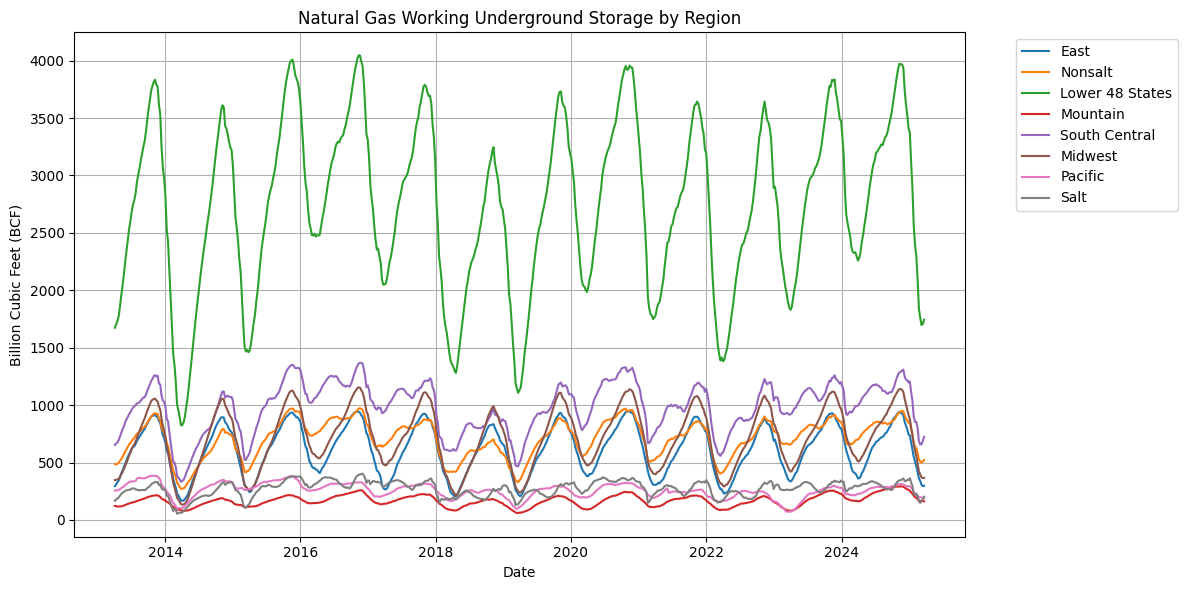

In [5]:
# Convert the JSON data to a Polars DataFrame
df = pl.DataFrame(data['response']['data'])

# Convert period to datetime and value to float
df = df.with_columns([
    pl.col('period').str.to_datetime(),
    pl.col('value').cast(pl.Float64)
])


# In the series description, remove the words "Weekly Natural Gas Working Underground Storage (Billion Cubic Feet)"
df = df.with_columns([
    pl.col('series-description')
        .str.replace('Natural Gas Working Underground Storage ', '')
        .str.replace('(Billion Cubic Feet)', '')
        .str.replace('Weekly ', '')
        .str.replace('Region', '')
        .str.replace(r'\([^)]*\)', '')
        .str.strip_chars()  # Changed from str.strip() to str.strip_chars()
        .alias('series-description')
])

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each series separately
for series_id in df['series'].unique():
    series_data = df.filter(pl.col('series') == series_id)
    plt.plot(
        series_data['period'], 
        series_data['value'],
        label=series_data['series-description'][0]
    )

# Customize the plot
plt.title('Natural Gas Working Underground Storage by Region')
plt.xlabel('Date')
plt.ylabel('Billion Cubic Feet (BCF)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Adjust layout to prevent label cutoff

# Show the plot
plt.show()

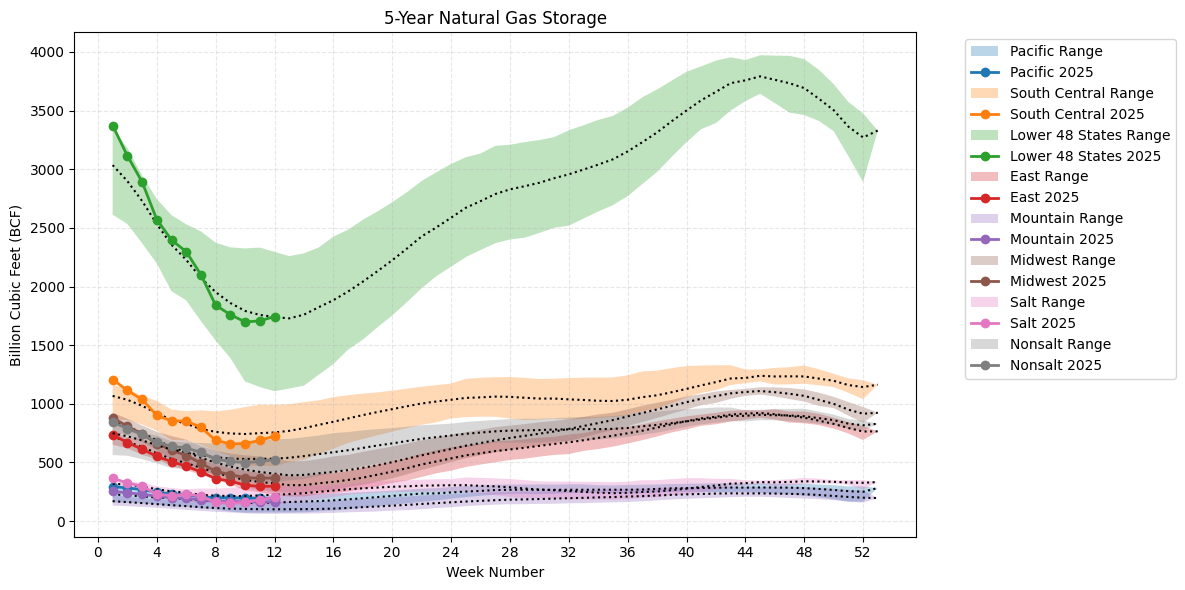

In [6]:
# Add week number column and filter for last 5 years
df = df.with_columns([
    pl.col('period').dt.week().alias('week'),
    pl.col('period').dt.year().alias('year')
])

# Filter for 2019-2024
df_5year = df.filter(
    (pl.col('year') >= 2019) & 
    (pl.col('year') <= 2024)
)

# Create the plot
plt.figure(figsize=(12, 6))

# For each series, create a separate subplot
for series_id in df_5year['series'].unique():
    series_data = df_5year.filter(pl.col('series') == series_id)
    
    # Group by week and calculate min/max/mean
    weekly_stats = series_data.group_by('week').agg([
        pl.col('value').min().alias('min_value'),
        pl.col('value').max().alias('max_value'),
        pl.col('value').mean().alias('mean_value')
    ]).sort('week')
    
    # Plot the range cloud
    plt.fill_between(
        weekly_stats['week'],
        weekly_stats['min_value'],
        weekly_stats['max_value'],
        alpha=0.3,
        label=f"{series_data['series-description'][0]} Range"
    )

    # Plot the mean line
    plt.plot(
        weekly_stats['week'],
        weekly_stats['mean_value'],
        linestyle='dotted',
        color='black'
    )

    # Plot the 2025 data
    storage_2025 = df.filter(
        (pl.col('series') == series_id) & 
        (pl.col('year') == 2025)
    )
    plt.plot(
        storage_2025['week'],
        storage_2025['value'],
        'o-',  # Dots connected by lines
        label=f"{series_data['series-description'][0]} 2025",
        linewidth=2
    )

# Customize the plot
plt.title('5-Year Natural Gas Storage')
plt.xlabel('Week Number')
plt.ylabel('Billion Cubic Feet (BCF)')
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Set x-axis ticks to show every 4th week
plt.xticks(range(0, 53, 4))

plt.tight_layout()
plt.show()

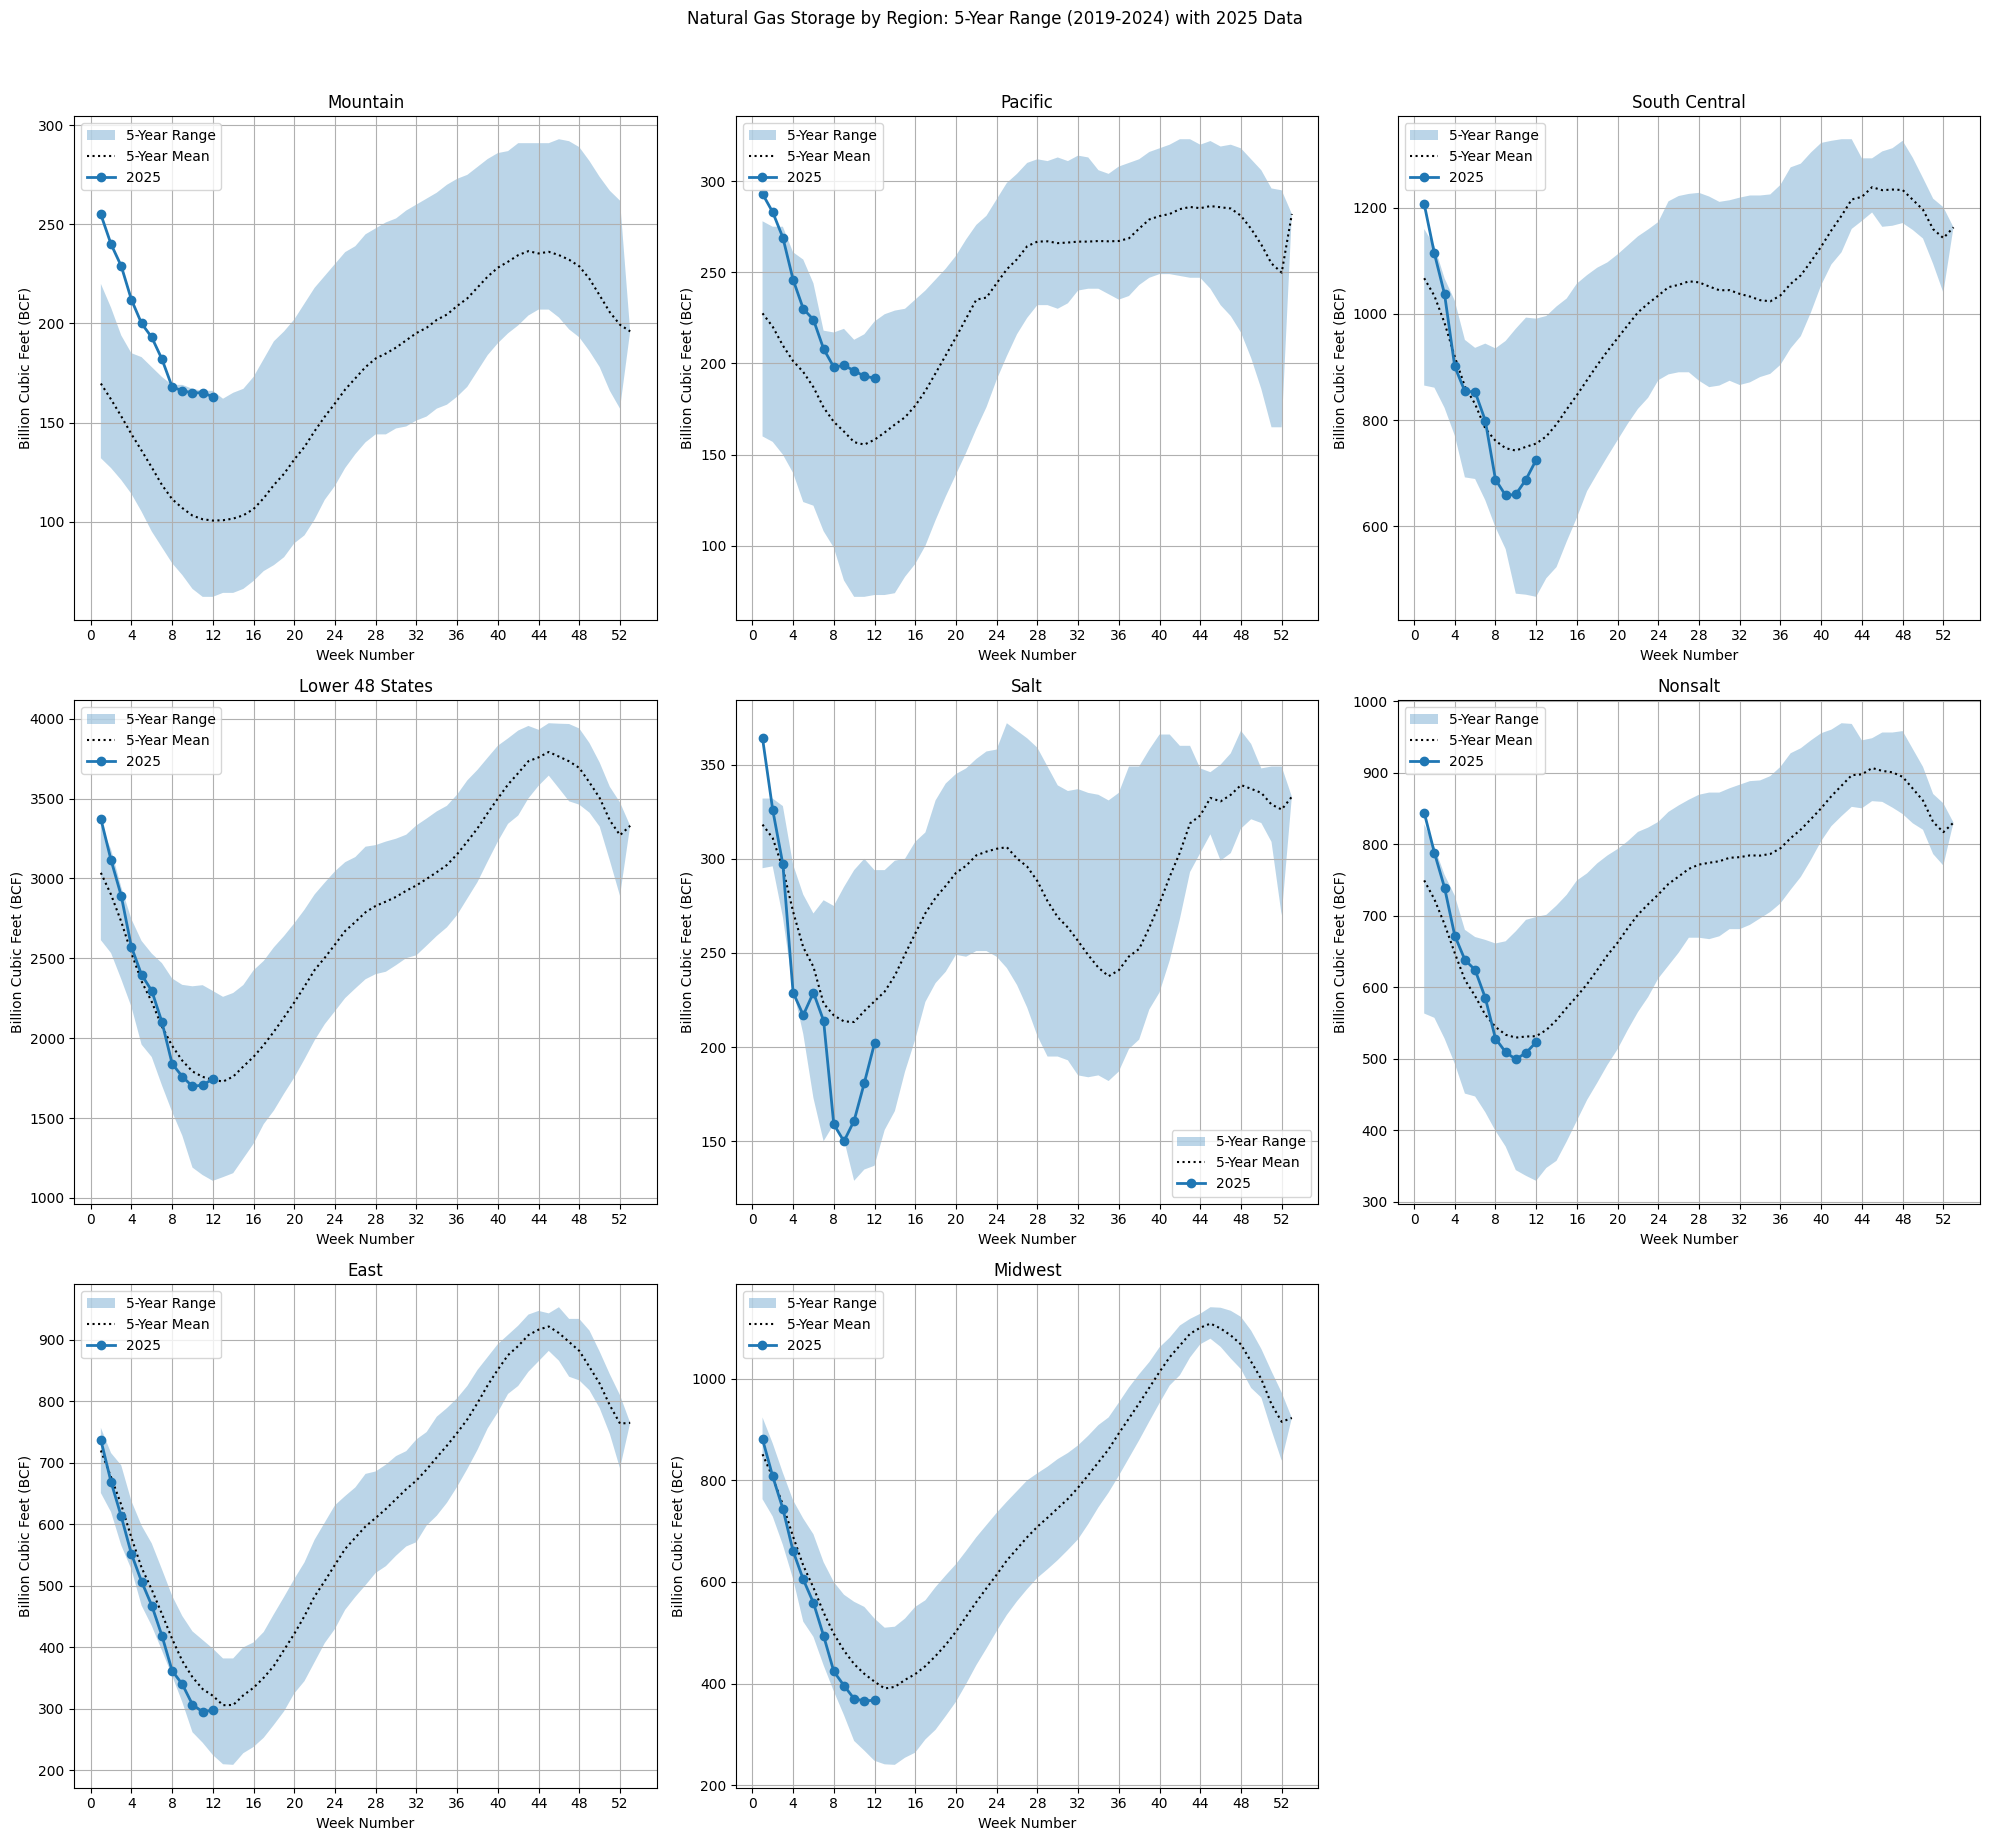

In [11]:
# Add week number column and filter for last 5 years
df = df.with_columns([
    pl.col('period').dt.week().alias('week'),
    pl.col('period').dt.year().alias('year')
])

# Filter for 2019-2024
df_5year = df.filter(
    (pl.col('year') >= 2019) & 
    (pl.col('year') <= 2024)
)

# Get unique series and calculate number of rows needed
unique_series = df_5year['series'].unique()
n_series = len(unique_series)
n_cols = 3
n_rows = (n_series + n_cols - 1) // n_cols

# Create figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
axs = axs.flatten() if n_rows > 1 else [axs]  # Flatten array for easier indexing

# Plot each region in its own subplot
for idx, series_id in enumerate(unique_series):
    series_data = df_5year.filter(pl.col('series') == series_id)
    
    # Group by week and calculate min/max/mean
    weekly_stats = series_data.group_by('week').agg([
        pl.col('value').min().alias('min_value'),
        pl.col('value').max().alias('max_value'),
        pl.col('value').mean().alias('mean_value')
    ]).sort('week')
    
    # Plot the range cloud
    axs[idx].fill_between(
        weekly_stats['week'],
        weekly_stats['min_value'],
        weekly_stats['max_value'],
        alpha=0.3,
        label='5-Year Range'
    )

    # Plot the mean line
    axs[idx].plot(
        weekly_stats['week'],
        weekly_stats['mean_value'],
        label='5-Year Mean',
        linestyle='dotted',
        color='black'
    )

    # Plot the 2025 data
    storage_2025 = df.filter(
        (pl.col('series') == series_id) & 
        (pl.col('year') == 2025)
    )
    axs[idx].plot(
        storage_2025['week'],
        storage_2025['value'],
        'o-',
        label='2025',
        linewidth=2
    )

    # Customize each subplot
    region_name = series_data['series-description'][0]
    axs[idx].set_title(region_name)
    axs[idx].set_xlabel('Week Number')
    axs[idx].set_ylabel('Billion Cubic Feet (BCF)')
    axs[idx].grid(True)
    axs[idx].legend()
    axs[idx].set_xticks(range(0, 53, 4))

# Remove any empty subplots
for idx in range(n_series, len(axs)):
    fig.delaxes(axs[idx])

plt.suptitle('Natural Gas Storage by Region: 5-Year Range (2019-2024) with 2025 Data', y=1.02)
plt.tight_layout()
plt.show()